In [7]:
import pandas as pd
import numpy as np

#for text pre-processing
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import seaborn as sns
import matplotlib.pyplot as plt

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

In [8]:
df_train = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')

In [9]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


0    4342
1    3271
Name: target, dtype: int64


C:\Users\abhil\anaconda3\envs\KerasPython37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


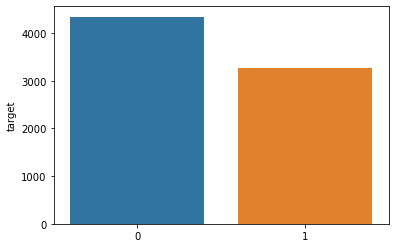

In [10]:
x = df_train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

In [11]:
# Missing values

df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
# Number of words in a tweet:

df_train['word_count'] = df_train['text'].apply(lambda x : len(str(x).split()))

# disaster tweets
print(df_train[df_train['target'] == 1]['word_count'].mean())

#Non disaster tweets
print(df_train[df_train['target'] == 0]['word_count'].mean())

15.167532864567411
14.704744357438969


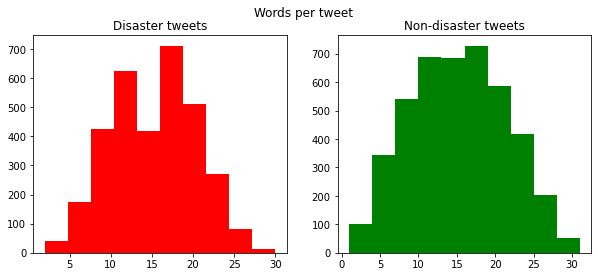

In [13]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=df_train[df_train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

In [14]:
# char count
df_train['char_count'] = df_train['text'].apply(lambda x : len(str(x)))

# disaster tweets
print(df_train[df_train['target'] == 1]['char_count'].mean())

#Non disaster tweets
print(df_train[df_train['target'] == 0]['char_count'].mean())

108.11342097217977
95.70681713496084


### Text preprocessing 

In [15]:
# Simple text cleaning processes
# Stop-word removal
# Stemming
# Lemmatization

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('',text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ',text) # replace %s with string punctuation
    text = re.sub('\s+',' ',text) #Matches any whitespace char
    text = re.sub(r'\[[0-9]*\]',' ',text) # Digits which are continuos are not removed ex 1234
    text = re.sub(r'[^\w\s]',' ',text.lower().strip()) # \w - matches alphanumeric chars - [a-zA-Z0-9_],\s - matches whitespace chars
    text = re.sub(r'\d',' ',text) # Matches any decimal digit, this is equivalent to the set class [0-9]
    text = re.sub(r'\s+',' ',text) # after removing digis we need to remove space once again
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    stopword = [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(stopword)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [16]:
def finalPreProcess(string):
       return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['text'].apply(lambda x : finalPreProcess(x))

df_train.head(5)

,id,keyword,location,text,target,word_count,char_count,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,get sent photo ruby alaska smoke wildfires pou...


### 4.Extracting vectors from text (Vectorization)

In [17]:
# The process to convert text data into numerical data/vector, is called vectorization or in the NLP world, word embedding

X_train, X_test, y_train, y_test = train_test_split(df_train['clean_text'], df_train['target'], test_size = 0.2, shuffle = True)

print(X_train.shape)
print(X_train)
#Word2Vec
# Word2Vec runs on tokenized sentences

x_train_tok = [nltk.word_tokenize(i) for i in X_train]
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

(6090,)
610                                fight bioterrorism sir
7122    nws wth rotate storm w report huge massive vio...
2575    sapphirescallop destroy oppa image oops nothin...
2755    year atomic bomb japan still struggle wartime ...
6458    remember marlene menahem moshav safsufa murder...
                              ...                        
6306                freeze fruit veggie http co meet mtpr
1333    mv strut like mean building burn bg flame ever...
6908       argentaelite haha traumatise hell want job xxx
536     paul rudd emile hirsch david gordon green prin...
4589    msnbc fuck idiot gun amp hatchet yet still ser...
Name: clean_text, Length: 6090, dtype: object


In [18]:
# TF-IDF

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(X_train_vectors_tfidf)

X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

  (0, 13227)	0.6377625077823958
  (0, 1352)	0.5589204600115576
  (0, 4826)	0.5299687755401994
  (1, 7088)	0.35466866365876315
  (1, 3459)	0.2876480945096842
  (1, 2515)	0.0645576254132673
  (1, 6473)	0.2008711556622471
  (1, 16222)	0.19784550465683884
  (1, 14653)	0.23891081233343772
  (1, 15583)	0.24953702263227145
  (1, 8909)	0.30541746488064686
  (1, 6486)	0.26828684432024813
  (1, 12156)	0.22030395102195563
  (1, 13793)	0.2008711556622471
  (1, 12499)	0.35466866365876315
  (1, 16303)	0.35466866365876315
  (1, 10150)	0.2876480945096842
  (2, 5915)	0.40904176967135436
  (2, 12325)	0.24915245177185108
  (2, 8227)	0.2587726931035666
  (2, 10044)	0.2910327698527463
  (2, 10459)	0.36749607430234726
  (2, 6754)	0.29637319069167395
  (2, 10475)	0.40904176967135436
  (2, 3394)	0.24783812288633378
  :	:
  (6088, 12585)	0.2818221334952201
  (6088, 11381)	0.2651133690282228
  (6088, 5649)	0.2651133690282228
  (6088, 5659)	0.27241224533311714
  (6088, 883)	0.21665107552573953
  (6088, 3170)	0.2

In [ ]:
#building Word2Vec model
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
def fit(self, X, y):
        return self
def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
w2v = dict(zip(model.wv.index2word, model.wv.syn0)) 
df['clean_text_tok']=[nltk.word_tokenize(i) for i in df['clean_text']]
model = Word2Vec(df['clean_text_tok'],min_count=1)     
modelw = MeanEmbeddingVectorizer(w2v)

# converting text to numerical data using Word2Vec
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

#### 5.Running ML algorithms

#### Logistic Regression

In [22]:
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       896
           1       0.73      0.73      0.73       627

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523

Confusion Matrix: [[729 167]
 [169 458]]
AUC: 0.8400404420141262


### Naive Bayes

In [23]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       896
           1       0.81      0.67      0.73       627

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Confusion Matrix: [[796 100]
 [208 419]]
AUC: 0.8452754756208704


In [25]:
#Pre-processing the new dataset
df_test['clean_text'] = df_test['text'].apply(lambda x: finalPreProcess(x)) #preprocess the data
X_test=df_test['clean_text'] 

#converting words to numerical data using tf-idf
X_vector=tfidf_vectorizer.transform(X_test)

#use the best model to predict 'target' value for the new dataset 
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target']= y_predict
final=df_test[['clean_text','target']].reset_index(drop=True)
print(final.head())

                                          clean_text  target
0                          happen terrible car crash       1
1  heard earthquake different city stay safe ever...       1
2  forest fire spot pond geese flee across street...       1
3                  apocalypse light spokane wildfire       1
4                 typhoon soudelor kill china taiwan       1
